In [1]:
import numpy as np
import h5py
import librosa
import smatrix
import torch
import matplotlib.pyplot as plt

## Scattering Matrix Computation


In [2]:
fs = 48000
alpha_lin = 0.5
alpha_vol = 0.5

### Series and Parallel Junctions


In [3]:
# port 7
Rin = 22e3
C71 = 4.7e-6
R72 = 50e3

Z_R71 = Rin
Z_C71 = 1 / (2 * fs * C71)
Z_S71 = Z_R71 + Z_C71
S_S71 = smatrix.series([Z_S71, Z_C71, Z_R71])

Z_R72 = R72
Z_P72 = (Z_S71 * Z_R72) / (Z_S71 + Z_R72)
S_P72 = smatrix.parallel([Z_P72, Z_R72, Z_S71])

# port 8
R81 = 22e3
C81 = 4.7e-6

Z_R81 = R81
Z_C81 = 1 / (2 * fs * C81)
Z_P81 = (Z_R81 * Z_C81) / (Z_R81 + Z_C81)
S_P81 = smatrix.parallel([Z_P81, Z_C81, Z_R81])

# port 9
C91 = 4.7e-6
Rout = 100e3
R_vol = 50e3
R92 = alpha_vol * R_vol
R93 = (1 - alpha_vol) * R_vol
C94 = 4.7e-6

Z_R91 = Rout
Z_C91 = 1 / (2 * fs * C91)
Z_S91 = Z_R91 + Z_C91
S_S91 = smatrix.series([Z_S91, Z_R91, Z_C91])

Z_R92 = R92
Z_P92 = (Z_R92 * Z_S91) / (Z_R92 + Z_S91)
S_P92 = smatrix.parallel([Z_P92, Z_R92, Z_S91])

Z_R93 = R93
Z_S93 = Z_R93 + Z_P92
S_S93 = smatrix.series([Z_S93, Z_R93, Z_P92])

Z_C94 = 1 / (2 * fs * C94)
Z_S94 = Z_C94 + Z_S93
S_S94 = smatrix.series([Z_S94, Z_C94, Z_S93])

### R-Type Junctions


In [4]:
# r-type port
R3 = 220e3
R5 = 22e3
R_lin = 10e3
R4 = (1 - alpha_lin) * R_lin
R6 = alpha_lin * R_lin
R10 = 1e-2
Vcc = 9.0

Z3 = R3
Z4 = R4
Z5 = R5
Z6 = R6
Z7 = Z_P72
Z8 = Z_P81
Z9 = Z_S94
Z10 = R10

# Read Scattering Matrix from HDF5 file computed by MATLAB
S_path = "S.hdf5"
S_name = "/S"
with h5py.File(S_path, "r") as file:
    S_matlab = file[S_name][:].T

# Read free-parameter impedance matrix from HDF5 file computed by MATLAB
Z_path = "Z.hdf5"
Z_name = "/Z"
with h5py.File(Z_path, "r") as file:
    Z_matlab = file[Z_name][:].T

fs_list = [44100, 48000, 88200, 96000, 176400, 192000]
alpha_lin_list = np.linspace(0, 1, 101)
alpha_vol_list = np.linspace(0, 1, 101)

fs_index = fs_list.index(fs)
alpha_lin_index = round(alpha_lin * 100)
alpha_vol_index = round(alpha_vol * 100)

# r-type junction
S = S_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :]

In [5]:
S

array([[ 0.00000000e+00,  0.00000000e+00, -6.42565419e-02,
        -3.21282388e-02,  4.79509384e-09,  3.21283031e-02,
         9.35743458e-01, -1.00000000e+00,  4.79509384e-09,
         3.21282340e-02],
       [ 0.00000000e+00,  0.00000000e+00,  6.42565560e-02,
         3.21289175e-02, -6.71652992e-01, -3.21276385e-02,
        -9.35743444e-01,  0.00000000e+00,  3.28347008e-01,
         6.39524074e-01],
       [-9.88462350e-01,  1.48469515e-04, -9.13983665e-01,
        -9.56990876e-01,  9.98628225e-05,  9.56992789e-01,
        -9.25372846e-01, -9.88462350e-01, -4.86066922e-05,
         9.56891013e-01],
       [-1.12322883e-02,  1.91439021e-06, -2.17497926e-02,
        -1.08738854e-02,  1.43667739e-06, -9.89124093e-01,
        -1.05155900e-02, -1.12322883e-02, -4.77712821e-07,
         1.01087245e+00],
       [-9.99694638e-01, -9.99849616e-01,  9.98628225e-06,
         6.32138051e-06, -3.28245709e-01, -3.66490174e-06,
        -1.44991744e-04, -9.99694638e-01, -3.28396093e-01,
         1.

### Two-Port Resistor


In [6]:
# two-port resistor parameters
R1 = 23e3
R2 = 12e3
R12 = np.diag([R1, R2])

Z12 = Z_matlab[fs_index, alpha_lin_index, alpha_vol_index, 0:2, 0:2]
Z12_inv = np.linalg.inv(Z12)
S_R = np.linalg.inv(R12 @ Z12_inv + np.eye(2)) @ (R12 @ Z12_inv - np.eye(2))

## Initialize Output Signals


In [7]:
n_ports = 10

Vin, fs = librosa.load("./matlab/input_fuzz_static.wav", sr=None)
Vin = Vin.reshape(-1, 1)
Vout = np.zeros_like(Vin)

a = np.zeros((n_ports, 1))
b = np.zeros((n_ports, 1))

b_S71 = np.zeros((3, 1))
b_P72 = np.zeros((3, 1))
b_P81 = np.zeros((3, 1))
b_S91 = np.zeros((3, 1))
b_P92 = np.zeros((3, 1))
b_S93 = np.zeros((3, 1))
b_S94 = np.zeros((3, 1))

## Solve DC Operating Point


In [8]:
isStable = False
error_eps = 1e-12

a_C71 = -3.7427606943372482
b_C71 = 0
a_C81 = 1.8297941172302856
b_C81 = 0
a_C91 = -4.440665733659135e-12
b_C91 = 0
a_C94 = -5.598253191650242
b_C94 = 0

ii = 0
while not isStable:
    ii += 1

    # Manage capacitors and inductors' states
    b_C71 = a_C71
    b_C81 = a_C81
    b_C91 = a_C91
    b_C94 = a_C94

    # Forward scanning
    # Port 6
    b_S71[0, 0] = S_S71[0, 1] * b_C71
    b_P72[0, 0] = S_P72[0, 2] * b_S71[0, 0]
    a[6, 0] = b_P72[0, 0]

    # Port 7
    b_P81[0, 0] = S_P81[0, 1] * b_C81
    a[7, 0] = b_P81[0, 0]

    # Port 8
    b_S91[0, 0] = S_S91[0, 2] * b_C91
    b_P92[0, 0] = S_P92[0, 2] * b_S91[0, 0]
    b_S93[0, 0] = S_S93[0, 2] * b_P92[0, 0]
    b_S94[0, 0] = S_S94[0, 1] * b_C94 + S_S94[0, 2] * b_S93[0, 0]
    a[8, 0] = b_S94[0, 0]

    # Port 9
    a[9, 0] = Vcc

    # Local scattering
    b[0, 0] = (
        S[0, 6] * a[6, 0] + S[0, 7] * a[7, 0] + S[0, 8] * a[8, 0] + S[0, 9] * a[9, 0]
    )
    b[1, 0] = (
        S[1, 6] * a[6, 0] + S[1, 7] * a[7, 0] + S[1, 8] * a[8, 0] + S[1, 9] * a[9, 0]
    )
    a[0, 0] = S_R[0, 0] * b[0, 0] + S_R[0, 1] * b[1, 0]
    a[1, 0] = S_R[1, 0] * b[0, 0] + S_R[1, 1] * b[1, 0]

    # Backward scanning
    # Port 6
    b[6, 0] = (
        S[6, 0] * a[0, 0]
        + S[6, 1] * a[1, 0]
        + S[6, 6] * a[6, 0]
        + S[6, 7] * a[7, 0]
        + S[6, 8] * a[8, 0]
        + S[6, 9] * a[9, 0]
    )
    b_P72[2, 0] = S_P72[2, 0] * b[6, 0] + S_P72[2, 2] * b_S71[0, 0]
    b_S71[1, 0] = S_S71[1, 0] * b_P72[2, 0] + S_S71[1, 1] * b_C71

    # Port 7
    b[7, 0] = (
        S[7, 0] * a[0, 0]
        + S[7, 1] * a[1, 0]
        + S[7, 6] * a[6, 0]
        + S[7, 7] * a[7, 0]
        + S[7, 8] * a[8, 0]
        + S[7, 9] * a[9, 0]
    )
    b_P81[1, 0] = S_P81[1, 0] * b[7, 0] + S_P81[1, 1] * b_C81
    b_P81[2, 0] = S_P81[2, 0] * b[7, 0] + S_P81[2, 1] * b_C81

    # Port 8
    b[8, 0] = (
        S[8, 0] * a[0, 0]
        + S[8, 1] * a[1, 0]
        + S[8, 6] * a[6, 0]
        + S[8, 7] * a[7, 0]
        + S[8, 8] * a[8, 0]
        + S[8, 9] * a[9, 0]
    )
    b_S94[1, 0] = (
        S_S94[1, 0] * b[8, 0] + S_S94[1, 1] * b_C94 + S_S94[1, 2] * b_S93[0, 0]
    )
    b_S94[2, 0] = (
        S_S94[2, 0] * b[8, 0] + S_S94[2, 1] * b_C94 + S_S94[2, 2] * b_S93[0, 0]
    )
    b_S93[2, 0] = S_S93[2, 0] * b_S94[2, 0] + S_S93[2, 2] * b_P92[0, 0]
    b_P92[2, 0] = S_P92[2, 0] * b_S93[2, 0] + S_P92[2, 2] * b_S91[0, 0]
    b_S91[2, 0] = S_S91[2, 0] * b_P92[2, 0] + S_S91[2, 2] * b_C91

    # Check if the states of capacitors and inductors are stable
    if (
        np.abs(b_C71 - b_S71[1][0]) > error_eps
        or np.abs(b_C81 - b_P81[1][0]) > error_eps
        or np.abs(b_C91 - b_S91[2][0]) > error_eps
        or np.abs(b_C94 - b_S94[1][0]) > error_eps
    ):
        a_C71 = b_S71[1][0]
        a_C81 = b_P81[1][0]
        a_C91 = b_S91[2][0]
        a_C94 = b_S94[1][0]
    else:
        isStable = True

print("Iterations:", ii)
print(
    "Stable states:\n  C71:",
    a_C71,
    "\n  C81:",
    a_C81,
    "\n  C91:",
    a_C91,
    "\n  C94:",
    a_C94,
)

Iterations: 1
Stable states:
  C71: -3.7427606943372482 
  C81: 1.8297941172302856 
  C91: -4.440665733659135e-12 
  C94: -5.598253191650242


## Simulation Loop (Element-wise Method)


In [9]:
for i in range(Vin.shape[0]):
    # Manage capacitors and inductors' states
    b_C71 = a_C71
    b_C81 = a_C81
    b_C91 = a_C91
    b_C94 = a_C94

    # Forward scanning: port 6
    b_S71[0, 0] = S_S71[0, 1] * b_C71 + S_S71[0, 2] * Vin[i, 0]
    b_P72[0, 0] = S_P72[0, 2] * b_S71[0, 0]
    a[6, 0] = b_P72[0, 0]

    # Forward scanning: port 7
    b_P81[0, 0] = S_P81[0, 1] * b_C81
    a[7, 0] = b_P81[0, 0]

    # Forward scanning: port 8
    b_S91[0, 0] = S_S91[0, 2] * b_C91
    b_P92[0, 0] = S_P92[0, 2] * b_S91[0, 0]
    b_S93[0, 0] = S_S93[0, 2] * b_P92[0, 0]
    b_S94[0, 0] = S_S94[0, 1] * b_C94 + S_S94[0, 2] * b_S93[0, 0]
    a[8, 0] = b_S94[0, 0]

    # Forward scanning: port 9
    a[9, 0] = Vcc

    # Local scattering
    b[0, 0] = (
        S[0, 6] * a[6, 0]
        + S[0, 7] * a[7, 0]
        + S[0, 8] * a[8, 0]
        + S[0, 9] * a[9, 0]
    )
    b[1, 0] = (
        S[1, 6] * a[6, 0]
        + S[1, 7] * a[7, 0]
        + S[1, 8] * a[8, 0]
        + S[1, 9] * a[9, 0]
    )
    a[0, 0] = S_R[0, 0] * b[0, 0] + S_R[0, 1] * b[1, 0]
    a[1, 0] = S_R[1, 0] * b[0, 0] + S_R[1, 1] * b[1, 0]

    # Backward scanning: port 6
    b[6, 0] = (
        S[6, 0] * a[0, 0]
        + S[6, 1] * a[1, 0]
        + S[6, 6] * a[6, 0]
        + S[6, 7] * a[7, 0]
        + S[6, 8] * a[8, 0]
        + S[6, 9] * a[9, 0]
    )
    b_P72[2, 0] = S_P72[2, 0] * b[6, 0] + S_P72[2, 2] * b_S71[0, 0]
    b_S71[1, 0] = S_S71[1, 0] * b_P72[2, 0] + S_S71[1, 1] * b_C71 + S_S71[1, 2] * Vin[i, 0]
    a_C71 = b_S71[1, 0]

    # Backward scanning: port 7
    b[7, 0] = (
        S[7, 0] * a[0, 0]
        + S[7, 1] * a[1, 0]
        + S[7, 6] * a[6, 0]
        + S[7, 7] * a[7, 0]
        + S[7, 8] * a[8, 0]
        + S[7, 9] * a[9, 0]
    )
    b_P81[1, 0] = S_P81[1, 0] * b[7, 0] + S_P81[1, 1] * b_C81
    a_C81 = b_P81[1, 0]

    # Backward scanning: port 8
    b[8, 0] = (
        S[8, 0] * a[0, 0]
        + S[8, 1] * a[1, 0]
        + S[8, 6] * a[6, 0]
        + S[8, 7] * a[7, 0]
        + S[8, 8] * a[8, 0]
        + S[8, 9] * a[9, 0]
    )
    b_S94[1, 0] = S_S94[1, 0] * b[8, 0] + S_S94[1, 1] * b_C94 + S_S94[1, 2] * b_S93[0, 0]
    b_S94[2, 0] = S_S94[2, 0] * b[8, 0] + S_S94[2, 1] * b_C94 + S_S94[2, 2] * b_S93[0, 0]
    b_S93[2, 0] = S_S93[2, 0] * b_S94[2, 0] + S_S93[2, 2] * b_P92[0, 0]
    b_P92[2, 0] = S_P92[2, 0] * b_S93[2, 0] + S_P92[2, 2] * b_S91[0, 0]
    b_S91[1, 0] = S_S91[1, 0] * b_P92[2, 0] + S_S91[1, 2] * b_C91
    b_S91[2, 0] = S_S91[2, 0] * b_P92[2, 0] + S_S91[2, 2] * b_C91
    a_C91 = b_S91[2, 0]
    a_C94 = b_S94[1, 0]
    Vout[i, 0] = b_S91[1, 0] / 2

KeyboardInterrupt: 

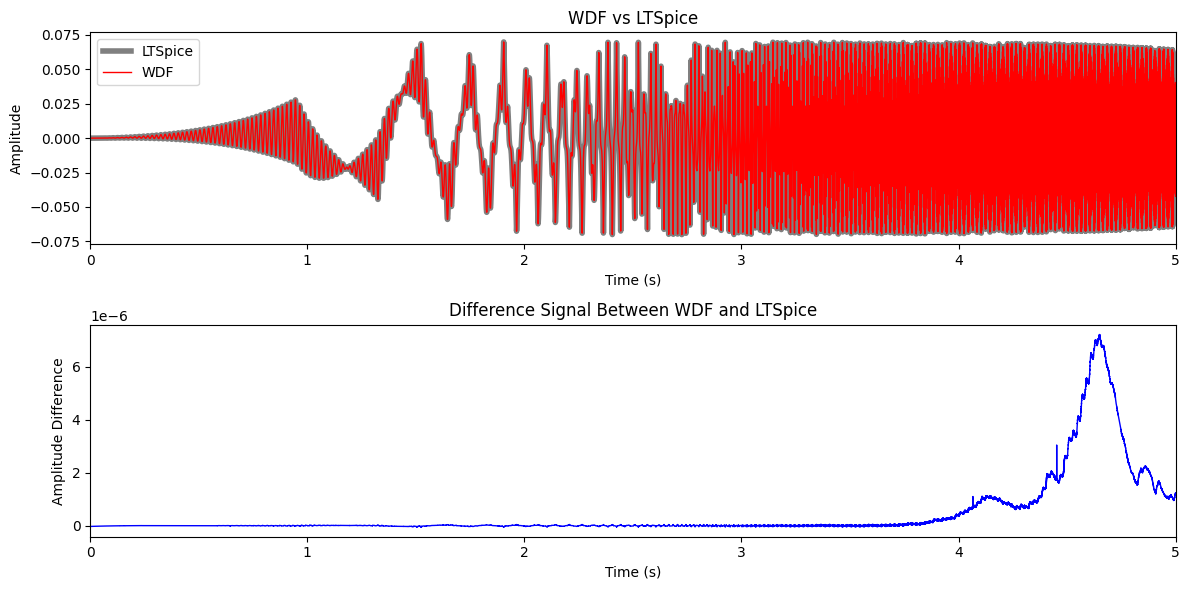

In [9]:
figsize = (12, 6)
xlim = (0, 5)

V_ltspice = librosa.load("./matlab/output_fuzz_static.wav", sr=None)[0].reshape(-1, 1)
y_axis = np.linspace(0, Vout.shape[0] / fs, Vout.shape[0])

# 创建一个图形和两个子图（ax1 和 ax2）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

# 在第一个子图上绘制原始信号对比
ax1.plot(y_axis, V_ltspice, color="grey", linewidth=4)
ax1.plot(y_axis, Vout, color="red", linewidth=1)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.set_title("WDF vs LTSpice")
ax1.legend(["LTSpice", "WDF"])
ax1.set_xlim(xlim)
# ax1.set_xticks(np.arange(0, 5.5, 0.5))

# 计算差值信号
diff_signal = V_ltspice - Vout

# 在第二个子图上绘制差值信号图
ax2.plot(y_axis, diff_signal, color="blue", linewidth=1)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude Difference")
ax2.set_title("Difference Signal Between WDF and LTSpice")
ax2.set_xlim(xlim)
# ax2.set_xticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()  # 调整子图的间距
plt.show()

# Neural Network Version


In [11]:
import torch
import h5py

class ResistorVector(torch.nn.Module):
    def __init__(self):
        super(ResistorVector, self).__init__()
        self.s11 = torch.nn.Parameter(torch.rand(()))
        self.s12 = torch.nn.Parameter(torch.rand(()))
        self.s21 = torch.nn.Parameter(torch.rand(()))
        self.s22 = torch.nn.Parameter(torch.rand(()))

    def forward(self, x):
        b1 = x[0, 0] * self.s11 + x[1, 0] * self.s12
        b2 = x[0, 0] * self.s21 + x[1, 0] * self.s22
        return torch.stack([b1, b2])


class FuzzStatic(torch.nn.Module):
    def __init__(self, alpha_lin=0.5, alpha_vol=0.5, fs=48e3, s_path="S.hdf5", z_path="Z.hdf5"):
        super(FuzzStatic, self).__init__()

        # Circuit parameters
        self.C71 = torch.tensor(4.7e-6)
        self.Rin = torch.tensor(22e3)
        self.R72 = torch.tensor(50e3)
        self.C81 = torch.tensor(4.7e-6)
        self.R81 = torch.tensor(22e3)
        self.Rout = torch.tensor(100e3)
        self.C91 = torch.tensor(4.7e-6)
        self.R_vol = torch.tensor(50e3)
        self.C94 = torch.tensor(4.7e-6)

        # Initialize scattering and free-parameter impedance matrices database from HDF5
        self.fs_dict = {
            44.1e3 : 0,
            48e3   : 1,
            88.2e3 : 2,
            96e3   : 3,
            176.4e3: 4,
            192e3  : 5
        }
        self.alpha_lin_list = torch.linspace(0, 1, 101)
        self.alpha_vol_list = torch.linspace(0, 1, 101)
        with h5py.File(s_path, "r") as file:
            self.S_matlab = torch.as_tensor(file["/S"][:].T)
        with h5py.File(z_path, "r") as file:
            self.Z_matlab = torch.as_tensor(file["/Z"][:].T)

        # Initialize circuit states
        self.set_circuit_states(alpha_lin, alpha_vol, fs)


    def set_circuit_states(self, alpha_lin: float, alpha_vol: float, fs: float):
        # Initialize scattering matrices
        self.compute_scattering_matrix_port7(fs)
        self.compute_scattering_matrix_port8(fs)
        self.compute_scattering_matrix_port9(alpha_vol, fs)
        self.compute_scattering_matrix_rtype(alpha_lin, alpha_vol, fs)

        # Initialize waves
        self.init_waves(fs)


    def compute_scattering_matrix_port7(self, fs):
        Z_R71 = self.Rin
        Z_C71 = 1 / (2 * fs * self.C71)
        self.Z_S71 = torch.stack((Z_R71 + Z_C71, Z_C71, Z_R71))
        self.S_S71 = self.scattering_matrix_series(self.Z_S71)

        Z_R72 = self.R72
        self.Z_P72 = torch.stack(((self.Z_S71[0] * Z_R72) / (self.Z_S71[0] + Z_R72), Z_R72, self.Z_S71[0]))
        self.S_P72 = self.scattering_matrix_parallel(self.Z_P72)


    def compute_scattering_matrix_port8(self, fs):
        Z_R81 = self.R81
        Z_C81 = 1 / (2 * fs * self.C81)
        self.Z_P81 = torch.stack(((Z_R81 * Z_C81) / (Z_R81 + Z_C81), Z_C81, Z_R81))
        self.S_P81 = self.scattering_matrix_parallel(self.Z_P81)


    def compute_scattering_matrix_port9(self, alpha_vol, fs):
        Z_R91 = self.Rout
        Z_C91 = 1 / (2 * fs * self.C91)
        self.Z_S91 = torch.stack((Z_R91 + Z_C91, Z_R91, Z_C91))
        self.S_S91 = self.scattering_matrix_series(self.Z_S91)

        R92 = alpha_vol * self.R_vol 
        Z_R92 = R92
        self.Z_P92 = torch.stack(((Z_R92 * self.Z_S91[0]) / (Z_R92 + self.Z_S91[0]), Z_R92, self.Z_S91[0]))
        self.S_P92 = self.scattering_matrix_parallel(self.Z_P92)

        R93 = (1 - alpha_vol) * self.R_vol
        Z_R93 = R93
        self.Z_S93 = torch.stack((Z_R93 + self.Z_P92[0], Z_R93, self.Z_P92[0]))
        self.S_S93 = self.scattering_matrix_series(self.Z_S93)

        Z_C94 = 1 / (2 * fs * self.C94)
        self.Z_S94 = torch.stack((Z_C94 + self.Z_S93[0], Z_C94, self.Z_S93[0]))
        self.S_S94 = self.scattering_matrix_series(self.Z_S94)


    def scattering_matrix_series(self, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental loop matrix of the series junction
        B = torch.ones(1, num_ports)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        S = torch.eye(num_ports) - 2 * Z @ B.T @ torch.inverse(B @ Z @ B.T) @ B
        
        # STEP 3: Return the scattering matrix
        return S


    def scattering_matrix_parallel(self, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental cut-set matrix
        Q = torch.ones(1, num_ports)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        Z_inv = torch.inverse(Z)
        S = 2 * Q.T @ torch.inverse(Q @ Z_inv @ Q.T) @ Q @ Z_inv - torch.eye(num_ports)
        
        # STEP 3: Return the scattering matrix
        return S


    def compute_scattering_matrix_rtype(self, alpha_lin, alpha_vol, fs):
        fs_index = self.fs_dict[fs]
        alpha_lin_index = round(alpha_lin * 100)
        alpha_vol_index = round(alpha_vol * 100)

        self.S = self.S_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :].to(dtype=torch.float32)
        self.Z = self.Z_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :].to(dtype=torch.float32)
        self.Z_t = self.Z[0:2, 0:2]


    def init_waves(self, fs):
        self.a_C71 = torch.tensor(-3.7427606943372482)
        self.a_C81 = torch.tensor(1.8297941172302856)
        self.a_C91 = torch.tensor(-4.440665733659135e-12)
        self.a_C94 = torch.tensor(-5.598253191650242)
        self.b_C71 = torch.tensor(0.0)
        self.b_C81 = torch.tensor(0.0)
        self.b_C91 = torch.tensor(0.0)
        self.b_C94 = torch.tensor(0.0)

        self.b_S71_0 = torch.tensor(0.0)
        self.b_P72_0 = torch.tensor(0.0)
        self.b_P81_0 = torch.tensor(0.0)
        self.b_S91_0 = torch.tensor(0.0)
        self.b_P92_0 = torch.tensor(0.0)
        self.b_S93_0 = torch.tensor(0.0)
        self.b_S94_0 = torch.tensor(0.0)
        self.b_S71_1 = torch.tensor(0.0)
        self.b_P81_1 = torch.tensor(0.0)
        self.b_S91_1 = torch.tensor(0.0)
        self.b_S94_1 = torch.tensor(0.0)
        self.b_P72_2 = torch.tensor(0.0)
        self.b_P81_2 = torch.tensor(0.0)
        self.b_S91_2 = torch.tensor(0.0)
        self.b_P92_2 = torch.tensor(0.0)
        self.b_S93_2 = torch.tensor(0.0)
        self.b_S94_2 = torch.tensor(0.0)

        self.a0 = torch.tensor(0.0)
        self.a1 = torch.tensor(0.0)
        self.a6 = torch.tensor(0.0)
        self.a7 = torch.tensor(0.0)
        self.a8 = torch.tensor(0.0)
        self.a9 = torch.tensor(9.0)

        self.b0 = torch.tensor(0.0)
        self.b1 = torch.tensor(0.0)
        self.b6 = torch.tensor(0.0)
        self.b7 = torch.tensor(0.0)
        self.b8 = torch.tensor(0.0)


    def forward(self, vin):
        vout = torch.zeros_like(vin)

        for i in range(vin.shape[0]):
            # Manage capacitors and inductors' states
            self.b_C71 = self.a_C71
            self.b_C81 = self.a_C81
            self.b_C91 = self.a_C91
            self.b_C94 = self.a_C94

            # Forward scanning: port 6
            self.b_S71_0 = self.S_S71[0, 1] * self.b_C71 + self.S_S71[0, 2] * vin[i, 0]
            self.b_P72_0 = self.S_P72[0, 2] * self.b_S71_0
            self.a6 = self.b_P72_0

            # Forward scanning: port 7
            self.b_P81_0 = self.S_P81[0, 1] * self.b_C81
            self.a7 = self.b_P81_0

            # Forward scanning: port 8
            self.b_S91_0 = self.S_S91[0, 2] * self.b_C91
            self.b_P92_0 = self.S_P92[0, 2] * self.b_S91_0
            self.b_S93_0 = self.S_S93[0, 2] * self.b_P92_0
            self.b_S94_0 = self.S_S94[0, 1] * self.b_C94 + self.S_S94[0, 2] * self.b_S93_0
            self.a8 = self.b_S94_0

            # Local scattering
            self.b0 = self.S[0, 6] * self.a6 + self.S[0, 7] * self.a7 + self.S[0, 8] * self.a8 + self.S[0, 9] * self.a9
            self.b1 = self.S[1, 6] * self.a6 + self.S[1, 7] * self.a7 + self.S[1, 8] * self.a8 + self.S[1, 9] * self.a9

            # TODO: Implement the following code
            # self.a0 = self.S_R[0, 0] * self.b0 + S_R[0, 1] * self.b1
            # self.a1 = self.S_R[1, 0] * self.b0 + S_R[1, 1] * self.b1
            
            # Backward scanning: port 6
            self.b6 = (
                self.S[6, 0] * self.a0
                + self.S[6, 1] * self.a1
                + self.S[6, 6] * self.a6
                + self.S[6, 7] * self.a7
                + self.S[6, 8] * self.a8
                + self.S[6, 9] * self.a9
            )
            self.b_P72_2 = (
                self.S_P72[2, 0] * self.b6
                + self.S_P72[2, 2] * self.b_S71_0
            )
            self.b_S71_1 = (
                self.S_S71[1, 0] * self.b_P72_2
                + self.S_S71[1, 1] * self.b_C71
                + self.S_S71[1, 2] * vin
            )
            self.a_C71 = b_S71[1, 0]
            
            # Backward scanning: port 7
            self.b7 = (
                self.S[7, 0] * self.a0
                + self.S[7, 1] * self.a1
                + self.S[7, 6] * self.a6
                + self.S[7, 7] * self.a7
                + self.S[7, 8] * self.a8
                + self.S[7, 9] * self.a9
            )
            self.b_P81_1 = self.S_P81_1 * self.b7 + self.S_P81_1 * self.b_C81
            self.b_P81_2 = self.S_P81_2 * self.b7 + self.S_P81_2 * self.b_C81
            self.a_C81 = self.b_P81_1
            
            # Port 8
            self.b8 = (
                self.S[8, 0] * self.a0
                + self.S[8, 1] * self.a1
                + self.S[8, 6] * self.a6
                + self.S[8, 7] * self.a7
                + self.S[8, 8] * self.a8
                + self.S[8, 9] * self.a9
            )
            self.b_S94_1 = self.S_S94[1, 0] * self.b8 + self.S_S94[1, 1] * self.b_C94 + self.S_S94[1, 2] * self.b_S93_0
            self.b_S94_2 = self.S_S94[2, 0] * self.b8 + self.S_S94[2, 1] * self.b_C94 + self.S_S94[2, 2] * self.b_S93_0
            self.b_S93_2 = self.S_S93[2, 0] * self.b_S94_2 + self.S_S93[2, 2] * self.b_P92_0
            self.b_P92_2 = self.S_P92[2, 0] * self.b_S93_2 + self.S_P92[2, 2] * self.b_S91_0
            self.b_S91_1 = self.S_S91[1, 0] * self.b_P92_2 + self.S_S91[1, 2] * self.b_C91
            self.b_S91_2 = self.S_S91[2, 0] * self.b_P92_2 + self.S_S91[2, 2] * self.b_C91
            self.a_C91 = self.b_S91_2
            self.a_C94 = self.b_S94_1
            
            vout[i, 0] = self.b_S91_1 / 2
        
        return vout
    


In [ ]:
model = FuzzStatic()